In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import sys, os, json

sys.path.append("../")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from kernels import GaussianKernel
from data import get_synthetic_dataset, get_synthetic_X, get_matrix_hermites, get_new_data
from feature_decomp import Monomial
from utils import ensure_torch
from tools import get_log_log_linear_fit

from ExptTrace import ExptTrace
from FileManager import FileManager

plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=14)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
plt.rc("mathtext", fontset='cm')

In [ ]:
from types import SimpleNamespace

def load_hypers(expt_dir, HypersCls=None):
    """
    expt_dir: directory that contains hypers.json
    HypersCls: pass the class/type of your original `hypers` (e.g., a dataclass).
               If None, returns a SimpleNamespace with attributes.
    """
    path = os.path.join(expt_dir, "hypers.json")
    if not os.path.isdir(expt_dir):
        raise FileNotFoundError(f"Experiment dir not found: {expt_dir}")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"hypers.json not found at: {path}")

    with open(path, "r") as f:
        data = json.load(f)

    if HypersCls is not None:
        return HypersCls(**data)
    return SimpleNamespace(**data)

In [ ]:
# SETUP FILE MANAGEMENT
#######################

exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", hypers.expt_name, hypers.dataset)
expt_dir = os.path.join(expt_dir, hypers.generate_filepath())

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [ ]:
from kernels import GaussianKernel
from data import get_synthetic_dataset, get_synthetic_X, get_matrix_hermites
from feature_decomp import Monomial, generate_fra_monomials
from utils import ensure_torch, ensure_numpy

import mupify
from mupify import mupify, rescale

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=1.2
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N)
target_monomials = monomials[:10]
lr = 1e-2
width = 8192
gamma = 1

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

num_trials = 2
max_iter = int(5e4)
loss_checkpoints = (5e-1, 2e-2)
percent_thresholds = (0.75, 0.5)

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

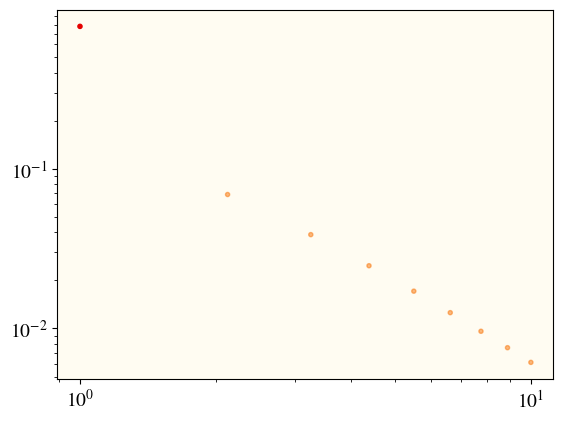

In [ ]:
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
pct_breakpoints = np.empty((len(target_monomials), len(percent_thresholds), num_trials))
pbar = tqdm(enumerate(target_monomials), total=len(target_monomials), desc="Processing items")

for idx, target_monomial in pbar:
    for trial in range(num_trials):
        model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
        _, losses, pct_breakpoint = train_network(model=model, lambdas=lambdas, Vt=Vt, monomial=target_monomial, dim=dim, bsz=bsz,
                                                  data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                  percent_thresholds=percent_thresholds, gamma=gamma, ema_smoother=0.9)
        all_losses[idx, trial] = losses
        pct_breakpoints[idx, :, trial] = pct_breakpoint
    pbar.set_postfix(current_item=target_monomial, iteration=idx + 1)
    if not(idx%10) and idx!=0:
        fig, axes = plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, plotindex=idx)
        fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
        plt.tight_layout(); plt.show()
        slope, intercept, xaxis = get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = idx)
        plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials, breakindex = 1, trainindex = idx)
        plt.show()
        print(f"Breakpoints: {pct_breakpoints[:idx, 1, :].mean(axis=-1)}")

Processing items:   0%|          | 0/10 [00:00<?, ?it/s]

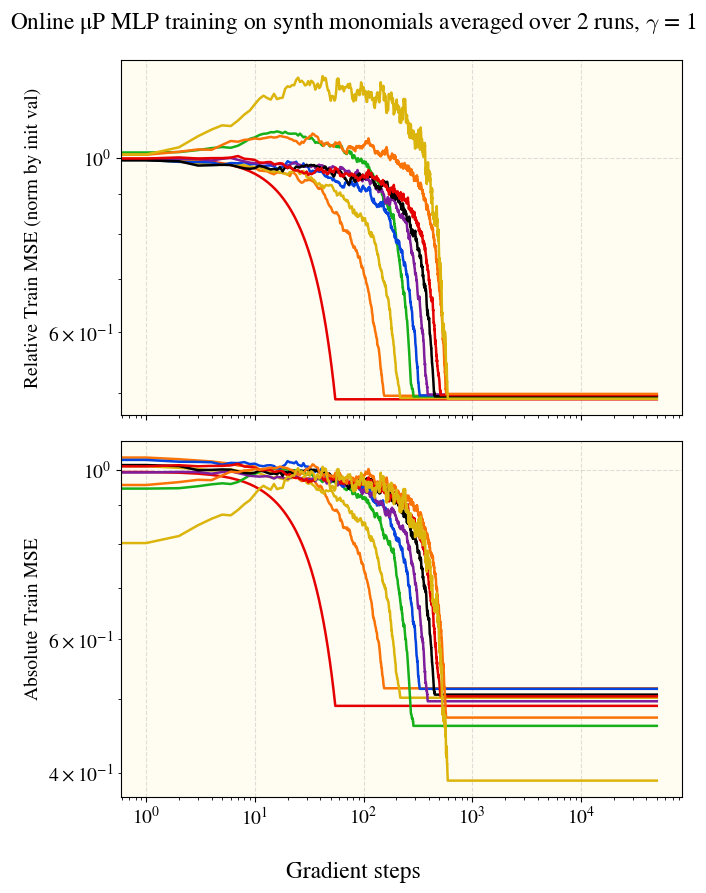

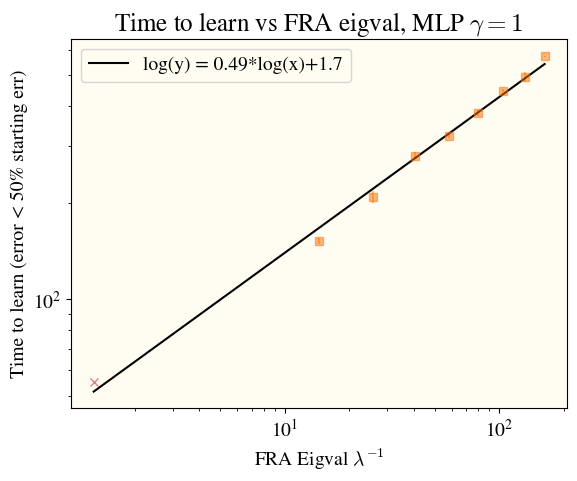

Breakpoints: [ 55.  152.  208.5 280.5 323.5 381.  447.5 494.  572.5]


In [ ]:
fig, axes = plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, plotindex=idx)
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
plt.tight_layout(); plt.show()
slope, intercept, xaxis = get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = idx)
plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials, breakindex = 1, trainindex = idx)
plt.show()
print(f"Breakpoints: {pct_breakpoints[:idx, 1, :].mean(axis=-1)}")

### testing new data gen

In [ ]:
all_losses

array([[[1.1182847 , 1.10277927, 1.1072278 , ..., 0.54735869,
         0.54735869, 0.54735869],
        [0.92241007, 0.92963321, 0.93327027, ..., 0.45955277,
         0.45955277, 0.45955277],
        [0.90082133, 0.90995547, 0.92507569, ..., 0.44669178,
         0.44669178, 0.44669178],
        [1.02848196, 1.02100505, 1.02210209, ..., 0.51032804,
         0.51032804, 0.51032804],
        [1.02304995, 1.02173135, 1.03568279, ..., 0.50820383,
         0.50820383, 0.50820383]],

       [[0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ]]])


Processing items:   0%|          | 0/10 [03:11<?, ?it/s]

Processing items:   0%|          | 0/20 [03:12<?, ?it/s, iteration=19]

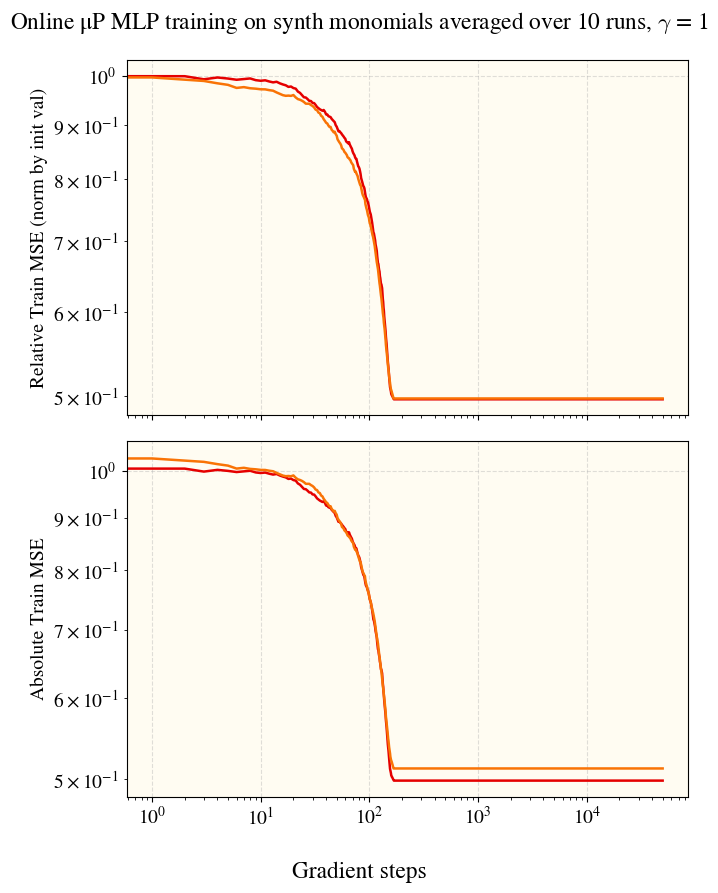

Breakpoints: [156.]


In [ ]:
num_trials = 10
all_losses = np.ones((len([0, 1]), num_trials, max_iter))*max(loss_checkpoints)
pct_breakpoints = np.empty((len([0, 1]), len(percent_thresholds), num_trials))
pbar = tqdm(range(2*num_trials), total=2*num_trials, desc="Processing items")
target_monomial = Monomial({0:1})
idx = 1

for mode in ["new", "old"]:
    if mode == "new":
        ppp = 0
    else:
        ppp = 1
    for trial in range(num_trials):
        model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
        _, losses, pct_breakpoint = train_network(model=model, lambdas=lambdas, Vt=Vt, monomial=target_monomial, dim=dim, bsz=bsz,
                                                  data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                  percent_thresholds=percent_thresholds, gamma=gamma, ema_smoother=0.9, mode=mode)
        all_losses[ppp, trial] = losses
        pct_breakpoints[ppp, :, trial] = pct_breakpoint
        pbar.set_postfix(iteration=(1+ppp)*trial + 1)

fig, axes = plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, plotindex=1)
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
plt.tight_layout(); plt.show()
slope, intercept, xaxis = get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = idx)
# plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials, breakindex = 1, trainindex = idx)
# plt.show()
print(f"Breakpoints: {pct_breakpoints[:idx, 1, :].mean(axis=-1)}")

In [ ]:
X, data_eigvals = get_synthetic_X(d=dim, N=N, offset=offset, alpha=alpha)

X, _, H, monomials, fra_eigvals, _, _ = get_synthetic_dataset(X, data_eigvals, noise_size=noise_size, yoffset=yoffset, beta=beta, normalized=True, kerneltype=kerneltype, **kwargs)

In [ ]:
def plot_time_to_learn_eigenvalue(eigvals, timekeys, target_monomials, scale='log', **kwargs):
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    uniq_md     = np.unique(max_degrees)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):
            plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            plt.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel(f"FRA Eigval $\\lambda^{{-1}}$")
    plt.ylabel(f"Time to learn "+kwargs.get("breakpoint", ""))
    plt.title(f"Time to learn vs FRA Eigval")


def plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, *, colors=None, plotindex = 26):
    colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"] if not colors else colors

    fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
    ax = axes[0]
    for idx, target_monomial in enumerate(target_monomials):
        if idx > plotindex:
            break
        ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("Relative Train MSE (norm by init val)")
    ax.grid(True, ls='--', alpha=.4)
    ax = axes[1]
    for idx, target_monomial in enumerate(target_monomials):
        if idx > plotindex:
            break
        ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("Absolute Train MSE")
    ax.grid(True, ls='--', alpha=.4)
    fig.supxlabel("Gradient steps")
    return fig, axes


def get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = 100):
    xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
    ys = ensure_torch(pct_breakpoints).mean(axis=-1)[:trainindex, breakindex]
    slope, intercept = get_log_log_linear_fit(xaxis, ys)
    return slope, intercept, xaxis


def plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials,
                             breakindex = 1, trainindex = 100, gamma=1, *, breakpoint=f"(error < 50% starting err)"):
    plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()][:trainindex].cpu(), pct_breakpoints.mean(axis=-1)[:trainindex, breakindex], target_monomials[:trainindex],
                                  scale='log', breakpoint=breakpoint, marker='s', alpha=0.5, errorbar=True, yerr=pct_breakpoints.var(axis=-1)[:trainindex, breakindex]**(0.5))
    plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
    plt.ylabel("Time to learn (error < 50% starting err)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")


import matplotlib.colors as mcolors
def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

In [ ]:
result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
ridge = result["ridge"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
source_exps = np.array(list(targets.keys()))

emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy")

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")